# Poisson regression (GAM) COVID-19 Prediction

In [95]:
# Data manipulation
import numpy as np
import pandas as pd

pd.options.display.max_columns = None
pd.options.display.max_colwidth = 500

# Data viz
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

sns.set(style="darkgrid", rc={"figure.figsize": (11.7, 8.27)})

# Modeling
from pygam import PoissonGAM, s, l, f

# Other
from datetime import date, timedelta
import os
import random
import sys

# Custom module
module_path = os.path.abspath(os.path.join("../src"))
if module_path not in sys.path:
    sys.path.append(module_path)

from plotting import plot_predictions
from stem_poisson_gam import StemPoissonRegressor

# Reload imported code
%reload_ext autoreload
%autoreload 2

# Print all output
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

# Set seeds for reproducibility
rand_seed = 2
np.random.seed(rand_seed)
random.seed(rand_seed)

## About

The goal is to provide the most accurate forecasts for COVID-19 in Canada for new cases, deaths and recovered cases.  We'll be using an approach similar to that in the paper [Spatiotemporal Dynamics, Nowcasting and Forecasting of COVID-19 in the United States](https://arxiv.org/abs/2004.14103) which uses a generalized additive model with Poisson distribution using temporal variables (number of infected, susceptible cases at time $t-1$), spatial coordinates, time varying covariates (control measures), and constant covariates (demographic, economic, etc). For now we only use temporal variables $I_{it}$ and $Z_{it}$.

## Load data and EDA

**Given variables**
- $Y_{it}$: Current number of new case at time t for area i. Column "cases" in cases_timeseries_prov.csv
- $I_{it}$: Cumulative number of active infectious cases. Column "active_cases" in active_timeseries_prov.csv
- $C_{it}$: Cumulative confirmed cases up to time t. Column "cumulative_cases" in active_timeseries_prov.csv
- $D_{it}$: Cumulative number of deaths. Column "cumulative_deaths" in active_timeseries_prov.csv
- $R_{it}$: Cumulative number of infections. Column "cumulative_recovered" in active_timeseries_prov.csv

**Transformed variables**
- $N_{i}$: Population of region i. Column "population"
- $S_{it}$: Number of susceptible subjects at time t defined by $S_{it} = N_i - C_{it}$. Column "susceptible"
- $Z_{it}$: Log ratio of susceptible subjects $Z_{it} = log(S_{it} / N_i)$. Column "percent_susceptible" without log transform.

In [96]:
# Read in data
data_path = '../data/timeseries_prov'
cases_provinces = pd.read_csv(data_path + '/cases_timeseries_prov.csv')
active_cases_provinces = pd.read_csv(data_path +  '/active_timeseries_prov.csv')

# Province population data
prov_map = {
    'British Columbia': 'BC',
    'Newfoundland and Labrador': 'NL', 
    'Northwest Territories': 'NWT',
    'Prince Edward Island': 'PEI'
}

province_populations = (
    pd.read_csv('../data/canada_prov_population.csv')
    .rename(columns = {'GEO': 'province', 'VALUE': 'population'})
    .replace({'province': prov_map})
    .loc[:, ['province', 'population']]
)


# Preprocessing
format = "%d-%m-%Y"

cases_provinces.rename(columns={'date_report': 'date'}, inplace=True)
                       
active_cases_provinces = (
    active_cases_provinces
    .rename(columns = {"date_active": "date"})
    .assign(date = lambda x: pd.to_datetime(x["date"], format=format).dt.date,
            cumulative_removed = lambda x: x["cumulative_cases"] + x["cumulative_recovered"],
            cases = cases_provinces['cases'])
    .query('province != "Repatriated"')
    .merge(province_populations, how='left', on='province')
    .assign(susceptible = lambda x: x['population'] - x['cumulative_cases'],
            percent_susceptible = lambda x: x['susceptible'] / x['population'])
)

# Get first and last day of reports
start_date = active_cases_provinces["date"].min()
end_date = active_cases_provinces["date"].max()

# Get list of provinces
provinces = active_cases_provinces["province"].unique()
provinces = ['Ontario', 'Quebec', 'BC', 'Alberta']

# Show dataframe
active_cases_provinces.head(10)

,province,date,cumulative_cases,cumulative_recovered,cumulative_deaths,active_cases,active_cases_change,cumulative_removed,cases,population,susceptible,percent_susceptible
0,Alberta,2020-01-25,0,0,0,0,0,0,0,4421876,4421876,1.0
1,Alberta,2020-01-26,0,0,0,0,0,0,0,4421876,4421876,1.0
2,Alberta,2020-01-27,0,0,0,0,0,0,0,4421876,4421876,1.0
3,Alberta,2020-01-28,0,0,0,0,0,0,0,4421876,4421876,1.0
4,Alberta,2020-01-29,0,0,0,0,0,0,0,4421876,4421876,1.0
5,Alberta,2020-01-30,0,0,0,0,0,0,0,4421876,4421876,1.0
6,Alberta,2020-01-31,0,0,0,0,0,0,0,4421876,4421876,1.0
7,Alberta,2020-02-01,0,0,0,0,0,0,0,4421876,4421876,1.0
8,Alberta,2020-02-02,0,0,0,0,0,0,0,4421876,4421876,1.0
9,Alberta,2020-02-03,0,0,0,0,0,0,0,4421876,4421876,1.0


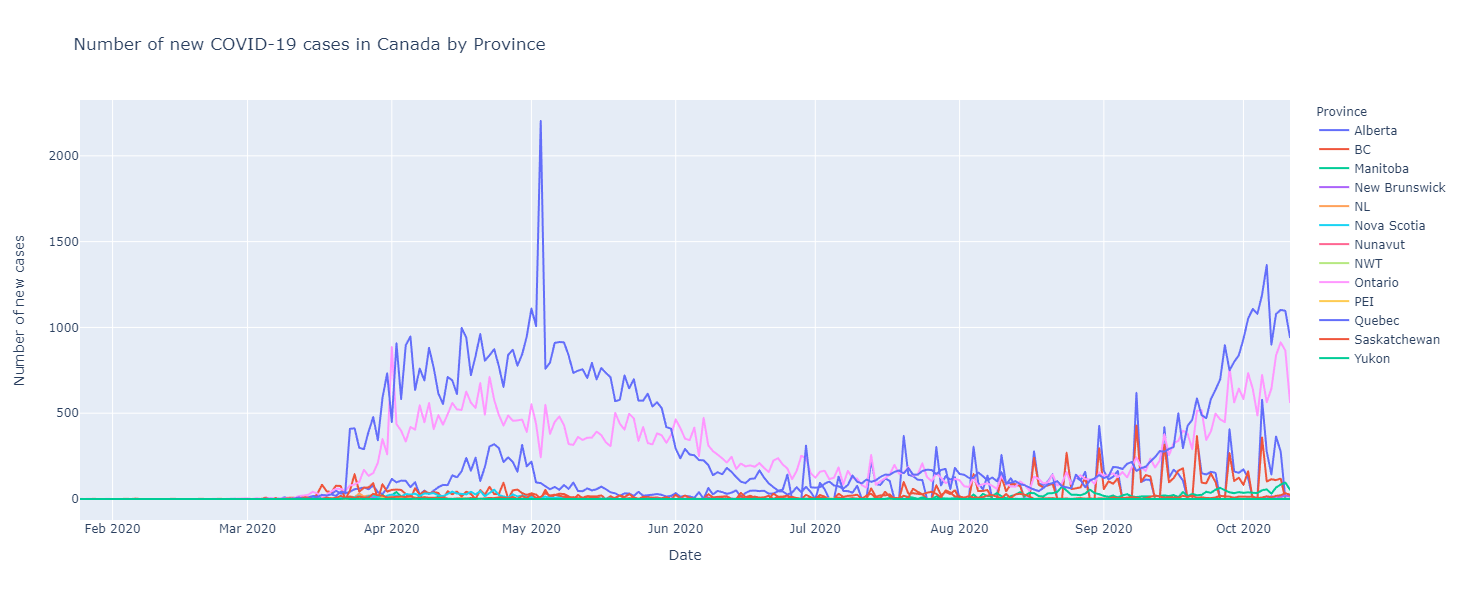

In [97]:
# Plot Y_it new cases for each province
fig = px.line(
    active_cases_provinces,
    x="date",
    y="cases",
    color="province",
    title="Number of new COVID-19 cases in Canada by Province",
    labels=dict(
        date="Date",
        cases="Number of new cases",
        province="Province",
    ),
    height=600,
)
fig.show()

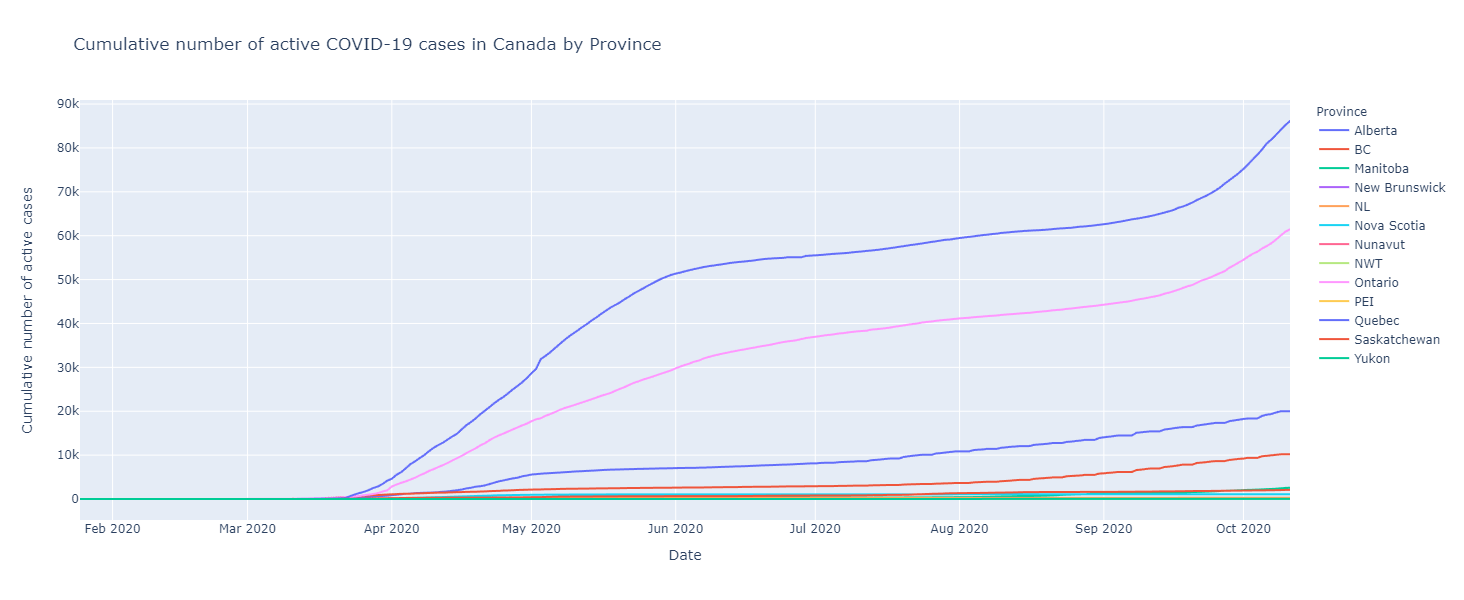

In [98]:
# Plot C_it cumulative active cases for each province
fig = px.line(
    active_cases_provinces,
    x="date",
    y="cumulative_cases",
    color="province",
    title="Cumulative number of active COVID-19 cases in Canada by Province",
    labels=dict(
        date="Date",
        cumulative_cases="Cumulative number of active cases",
        province="Province",
    ),
    height=600,
)
fig.show()

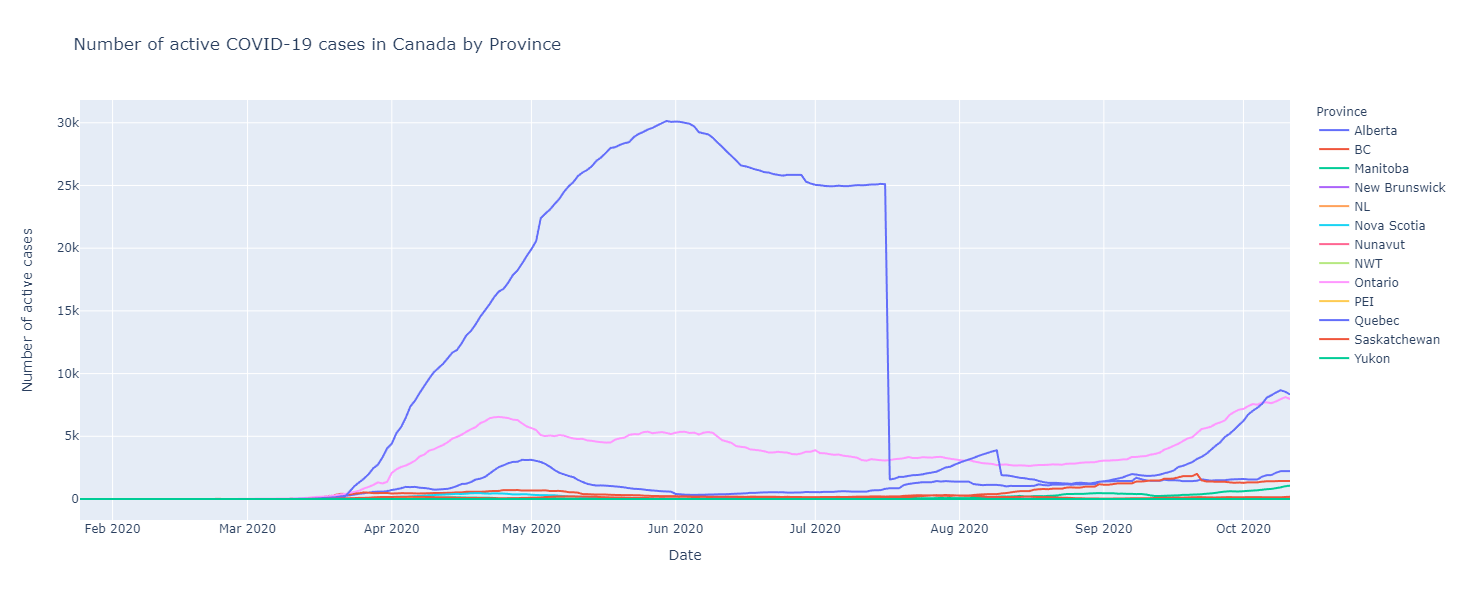

In [99]:
# Plot I_it new cases for each province
fig = px.line(
    active_cases_provinces,
    x="date",
    y="active_cases",
    color="province",
    title="Number of active COVID-19 cases in Canada by Province",
    labels=dict(
        date="Date",
        active_cases="Number of active cases",
        province="Province",
    ),
    height=600,
)
fig.show()

### Comments

- Seems to be a seasonal component in the $Y_{it}$ plot of about 1 week appeearing roughly on Mondays and Tuesdays. This could be that the most testing happens over the weekends and thus the cases are displayed the start of the next week.
- Large dip in active cases in Quebec on July 17 - https://globalnews.ca/news/7190163/canada-coronavirus-cases-july-17/\
- Spike in new cases in Quebec on May 3- https://www.cbc.ca/news/canada/montreal/covid-19-quebec-may-3-1.5553881
- Warning: Innacurate measurements of new and active cases, recovered, deaths, etc such as this could add too much noise and lead to poor model performance. Might be a good idea to ignore that portion of Quebec and use the latest data instead.

## Poisson regression

For a given province $i$ we have

$$
Y_t \sim Poisson(\mu_t) \\
log(\mu_t) = \beta_{1t} + \beta_{2t}log(I_{t-1} + 1) + \alpha_tlog(S_{t-1}/N) 
$$

We will also be applying cross-validation on each fold to prevent overfitting.

In [100]:
# Filter Ontario
cases_ontario = active_cases_provinces.query('province == "Ontario"')

# Fit poisson model
X = cases_ontario[['date', 'active_cases', 'percent_susceptible']]
Y = cases_ontario[['cases', 'cumulative_removed']]


stem_poisson = StemPoissonRegressor()
stem_poisson.fit(X, Y)

stem_poisson.poisson_gam_cases.summary()

PoissonGAM                                                                                                
=============================================== ==========================================================
Distribution:                       PoissonDist Effective DoF:                                      2.0946
Link Function:                          LogLink Log Likelihood:                                 -7617.8847
Number of Samples:                          260 AIC:                                            15239.9585
                                                AICc:                                           15240.0576
                                                UBRE:                                              54.5223
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.7359
Feature Function                  Lam

<ipython-input-100-f491a356fa5a>:12: UserWarning:

KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 




In [121]:
# Get h step predictions
C = cases_ontario['cumulative_cases'].iloc[-1]
N = cases_ontario['population'].iloc[-1]
h = 14 #2 weeks
forecasts = stem_poisson.forecast(C = C, N = N, h = h)

In [113]:
cases_ontario.tail()

,province,date,cumulative_cases,cumulative_recovered,cumulative_deaths,active_cases,active_cases_change,cumulative_removed,cases,population,susceptible,percent_susceptible
2344,Ontario,2020-10-07,58285,47613,3032,7640,-65,105898,643,14734014,14675729,0.996044
2345,Ontario,2020-10-08,59122,48308,3035,7779,139,107430,837,14734014,14674892,0.995987
2346,Ontario,2020-10-09,60035,49032,3040,7963,184,109067,913,14734014,14673979,0.995925
2347,Ontario,2020-10-10,60900,49732,3047,8121,158,110632,865,14734014,14673114,0.995867
2348,Ontario,2020-10-11,61464,50437,3049,7978,-143,111901,564,14734014,14672550,0.995828


In [122]:
forecasts.tail(15)

,date,cases_pred,cumulative_removed_pred,active_cases_pred,is_forecast
259,2020-10-11,568.904925,9.098927e+04,NaN,False
260,2020-10-12,558.430800,8.996973e+04,3.046770e+04,True
261,2020-10-13,2121.239610,2.092533e+05,1.000000e+00,True
262,2020-10-14,0.071933,3.134999e+02,2.089409e+05,True
263,2020-10-15,14410.029620,7.037144e+05,1.000000e+00,True
264,2020-10-16,0.070557,3.134999e+02,7.034020e+05,True
265,2020-10-17,47385.400103,1.511732e+06,1.000000e+00,True
266,2020-10-18,0.066206,3.134999e+02,1.511419e+06,True
267,2020-10-19,95288.882500,2.447488e+06,1.000000e+00,True
268,2020-10-20,0.058216,3.134999e+02,2.447176e+06,True


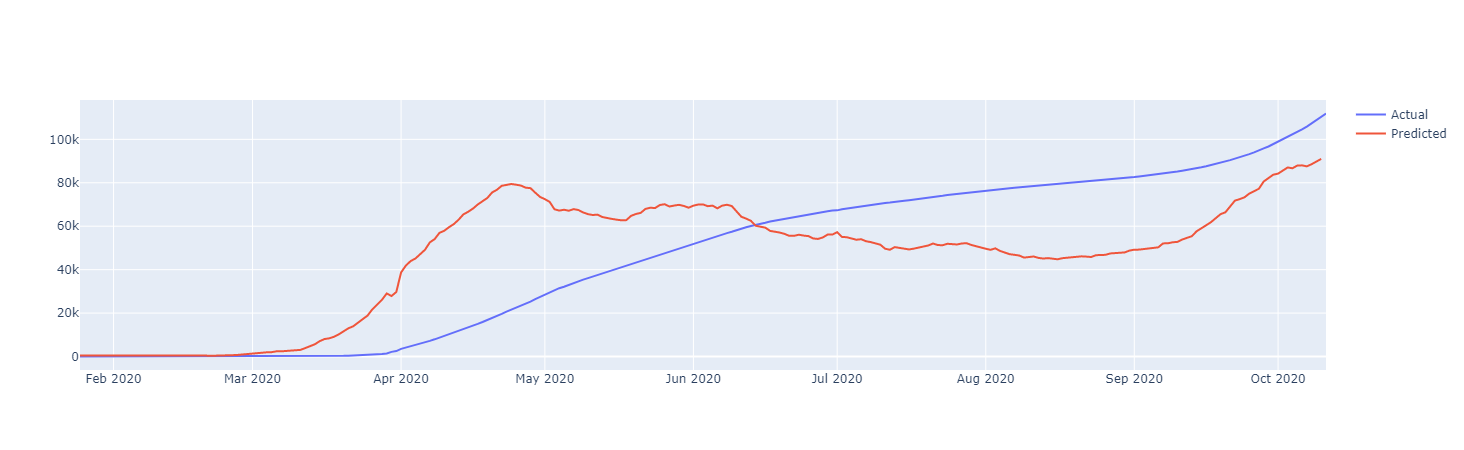

In [10]:
# Get predictions and confidence intervals of E[Y|X]
y_pred = stem_poisson.poisson_gam_removed.predict(stem_poisson.X_removed)

# Plot predictions
fig = go.Figure()

fig = fig.add_trace(
    go.Scatter(
        x = cases_ontario['date'],
        y = cases_ontario['cumulative_removed'],
        mode = 'lines',
        name = 'Actual'
    )
)

fig = fig.add_trace(
    go.Scatter(
        x = cases_ontario['date'],
        y = y_pred,
        mode = 'lines',
        name = 'Predicted'
    )
)

# fig = fig.add_trace(
#     go.Scatter(
#         x = cases_ontario['date'],
#         y = y_ci[:, 1],
#         mode = 'lines',
#         name = 'CI Upper'
#     )
# )

# fig = fig.add_trace(
#     go.Scatter(
#         x = cases_ontario['date'],
#         y = y_ci[:, 0],
#         mode = 'lines',
#         name = 'CI Lower'
#     )
# )

fig